In [145]:
%config IPCompleter.greedy=True

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision import transforms, datasets
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
import os

torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name() if torch_device.type == 'cuda' else 'cpu'
print(f'Using device: {device_name}, type {torch_device}')

Using device: cpu, type cpu


In [352]:
cifar_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
def load_cifar():
    train_transforms = [
        transforms.Pad(4, padding_mode='reflect'),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ]

    test_transforms = [
        transforms.ToTensor(),
        #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ]

    cifar_train = datasets.CIFAR10('./datasets', train=True, download=True,
                                   transform=transforms.Compose(train_transforms))
    cifar_test = datasets.CIFAR10('./datasets', train=False, download=True,
                                  transform=transforms.Compose(test_transforms))

    batch_size = 256
    train_dataset = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_dataset = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_dataset, test_dataset

def load_mnist():
    all_transforms = [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    mnist_train = datasets.MNIST('./datasets', train=True, download=True,
                                 transform=transforms.Compose(all_transforms))
    mnist_test = datasets.MNIST('./datasets', train=False, download=True,
                                transform=transforms.Compose(all_transforms))

    batch_size = 256
    train_dataset = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_dataset = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=2)

    return train_dataset, test_dataset

# Util Functions

In [346]:
class Student(nn.Module):
    def __init__(self, temperature, in_dims=3):
        super(Student, self).__init__()
        self.temperature = temperature
        self.cnn1 = nn.Conv2d(in_dims, 32, kernel_size=(3, 3))
        self.bn1 = nn.BatchNorm2d(32)
        self.mp1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.cnn2 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.bn2 = nn.BatchNorm2d(64)
        self.mp2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.fc1 = nn.Linear(2304, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.mp1(F.relu(self.bn1(self.cnn1(x))))
        x = self.mp2(F.relu(self.bn2(self.cnn2(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.dropout(F.relu(self.fc1(x)), p=0.2)
        x = F.dropout(F.relu(self.fc2(x)), p=0.2)
        x = self.fc3(x)
        soft_target = F.log_softmax(x / self.temperature, dim=1)
        hard_target = F.log_softmax(x, dim=1)

        return soft_target, hard_target, F.softmax(x / self.temperature, dim=1), F.softmax(x, dim=1)
    
def create_student(temperature, device, in_dims=3):
    return Student(temperature, in_dims).to(device)

def calc_accuracy(model, device):
    correct = 0
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(test):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            pred_class = torch.argmax(preds, dim=1)
            correct += torch.eq(pred_class, labels).sum()
    return f'{(correct * 100) / len(test.dataset):.2f}%'

def list_files(dir_name):
    r = []
    for root, dirs, files in os.walk(dir_name):
        for name in files:
            r.append(os.path.join(root, name))
    return r

def parse_file_name(name):
    parts = name.split('_')
    # Returns the temperature and alpha values from the filename
    return parts[4][1:], parts[5][1:].replace('-', '.')[:-3]

# Plot temperature vs alpha heatmap

In [58]:
# Iterate over all files
# Skip any .pickle
# Load the model
    # Parse the filename
    # Store formatted data
    
student_model = create_student(torch_device)
d = {'alpha': [], 'temperature': [], 'acc': []}
all_files = list_files('../results/bst')
for i, file_name in enumerate(all_files):
    if file_name.endswith('pickle') or file_name.endswith('Store'):
        continue
    
    student_model.load_state_dict(torch.load(file_name, map_location=torch_device))
    student_model.eval()
    test_acc = calc_accuracy(student_model, torch_device)
    temperature, alpha = parse_file_name(file_name)
    d['alpha'].append(float(alpha))
    d['temperature'].append(int(temperature))
    d['acc'].append(float(test_acc) / 100)
    print(f'temp: {temperature}, alpha: {alpha}, test_acc: {test_acc}')

temp: 20, alpha: 0.9, test_acc: 72.43%
temp: 20, alpha: 0.5, test_acc: 75.58%
temp: 20, alpha: 0.1, test_acc: 77.49%
temp: 10, alpha: 0.9, test_acc: 72.67%
temp: 10, alpha: 0.1, test_acc: 78.14%
temp: 10, alpha: 0.5, test_acc: 76.57%
temp: 5, alpha: 0.9, test_acc: 73.42%
temp: 5, alpha: 0.1, test_acc: 77.99%
temp: 5, alpha: 0.5, test_acc: 76.73%
temp: 2, alpha: 0.1, test_acc: 77.28%
temp: 2, alpha: 0.5, test_acc: 76.44%
temp: 2, alpha: 0.9, test_acc: 74.93%
temp: 15, alpha: 0.1, test_acc: 78.02%
temp: 15, alpha: 0.5, test_acc: 76.13%
temp: 15, alpha: 0.9, test_acc: 72.93%
temp: 7, alpha: 0.9, test_acc: 74.27%
temp: 7, alpha: 0.1, test_acc: 77.56%
temp: 7, alpha: 0.5, test_acc: 76.27%


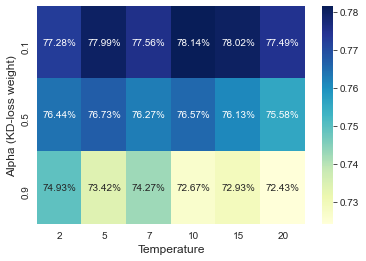

In [89]:
df = pd.DataFrame(data=d).sort_values('temperature')
result = df.pivot(index='alpha', columns='temperature', values='acc')

with sns.axes_style('white'):
    ax = sns.heatmap(result, annot=True, fmt='.2%', cmap='YlGnBu')
    ax.set(xlabel='Temperature', ylabel='Alpha (KD-loss weight)')
    plt.show()
    ax.get_figure().savefig('kd_temp_alpha.png', dpi=400)

# Effect of temperature on probability of targets (cifar)

cat


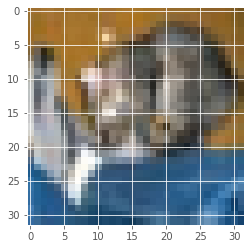

In [341]:
student_model = create_student(1, torch_device)
student_model.load_state_dict(torch.load('../models/student_cifar.pt', map_location=torch_device))
student_model.eval()

train, test = load_cifar()
img, label = test.dataset[0]
img = img.permute(1,2,0)
print(cifar_class_names[label])
plt.imshow(img)
plt.savefig('cat_test_img', dpi=400)

results = []
img, label = test.dataset[0]
img = img.unsqueeze(0)
for i in [1, 3, 5, 7, 10, 15, 20]:
    student_model = create_student(i, torch_device)
    student_model.load_state_dict(torch.load('../models/student_cifar.pt', map_location=torch_device))
    student_model.eval()
    
    with torch.no_grad():  
        _, _, out, _ = student_model(img)
        results.append((i, out.squeeze().numpy()))

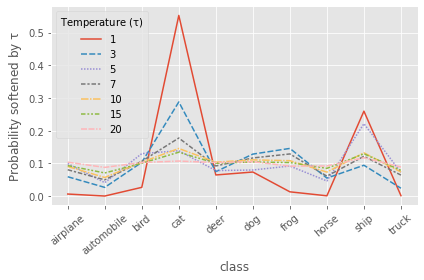

In [343]:
d_temp = {'prob': [], 'class': [], 'temperature': []}
for i in results:
    for index, prob in enumerate(i[1]):
        d_temp['prob'].append(prob)
        d_temp['class'].append(cifar_class_names[index])
        d_temp['temperature'].append(int(i[0]))
temp_df = pd.DataFrame(data=d_temp)
temp_wide = temp_df.pivot('class', 'temperature', 'prob')

#with sns.axes_style('white'):
ax = sns.lineplot(data=temp_wide)
ax.legend(title=r'Temperature ($\mathrm{\tau})$')
ax.set(xlabel='class', ylabel=r'Probability softened by $\mathrm{\tau}$')
plt.xticks(plt.xticks()[0], cifar_class_names, rotation=40)
plt.tight_layout()
plt.show()
ax.get_figure().savefig('cat_test_plot.png', dpi=400)

# Effect of temperature on probability of targets (mnist)

In [348]:
def create_student_mnist(temperature, device): 
    return nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Conv2d(16, 32, kernel_size=(3, 3)),
        nn.Flatten(),
        nn.Linear(3872, 10),
        SoftmaxT(temperature)
    ).to(device)

7


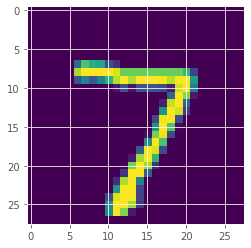

In [356]:
student_model = create_student_mnist(1, torch_device)
student_model.load_state_dict(torch.load('../models/student_mnist.pt', map_location=torch_device))
student_model.eval()

train, test = load_mnist()
img, label = test.dataset[0]
img = img.permute(1,2,0)
print(label)
plt.imshow(img)
plt.savefig('mnist_test_img', dpi=400)

results = []
img, label = test.dataset[0]
img = img.unsqueeze(0)
for i in [1, 3, 5, 7, 10, 15, 20]:
    student_model = create_student_mnist(i, torch_device)
    student_model.load_state_dict(torch.load('../models/student_mnist.pt', map_location=torch_device))
    student_model.eval()
    
    with torch.no_grad():  
        out = student_model(img)
        results.append((i, out.squeeze().numpy()))

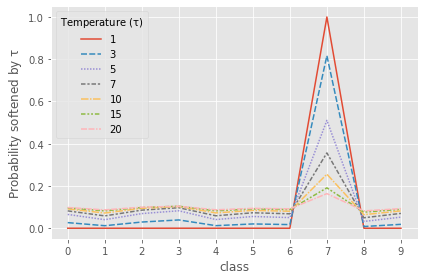

In [365]:
d_temp_mnist = {'prob': [], 'class': [], 'temperature': []}
for i in results:
    for index, prob in enumerate(i[1]):
        d_temp_mnist['prob'].append(prob)
        d_temp_mnist['class'].append(index)
        d_temp_mnist['temperature'].append(int(i[0]))
temp_df_mnist = pd.DataFrame(data=d_temp_mnist)
temp_wide_mnist = temp_df_mnist.pivot('class', 'temperature', 'prob')

#with sns.axes_style('white'):
ax = sns.lineplot(data=temp_wide_mnist)
ax.legend(title=r'Temperature ($\mathrm{\tau})$')
ax.set(xlabel='class', ylabel=r'Probability softened by $\mathrm{\tau}$')
plt.xticks(np.arange(0, 9+1, 1.0))
plt.tight_layout()
plt.show()
ax.get_figure().savefig('mnist_temperature_plot.png', dpi=400)